# Data visualization
---
- Interpretting the data visually and through statistics.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from statsmodels.graphics.tsaplots import plot_acf

Configuration of plotting and colors

In [7]:
vir_col = plt.get_cmap("viridis")
plt.style.use("ggplot")
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'
pd.set_option('display.float_format', '{:.2f}'.format)

In [8]:
dataset = pd.read_pickle("train_clean.pkl")
dataset.head(3)

,Sales,Customers,Store,Date,DayOfWeek,Week,Month,Year,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,LogCompetitionDistance,CompetitionMonthsKnown,CompetitionMonthsTotal,Promo2,Promo2MonthsTotal,Promo2CurrentlyOn
0,5263,555,1,2015-07-31,5,31,7,2015,1,1,0,1,c,a,7.15,1,82,0,0.00,0
1,6064,625,2,2015-07-31,5,31,7,2015,1,1,0,1,a,a,6.35,1,92,1,64.50,1
2,8314,821,3,2015-07-31,5,31,7,2015,1,1,0,1,a,a,9.56,1,103,1,52.25,1


count   1017209.00
mean       5773.82
std        3849.93
min           0.00
25%        3727.00
50%        5744.00
75%        7856.00
max       41551.00
Name: Sales, dtype: float64

count   1017209.00
mean        633.15
std         464.41
min           0.00
25%         405.00
50%         609.00
75%         837.00
max        7388.00
Name: Customers, dtype: float64

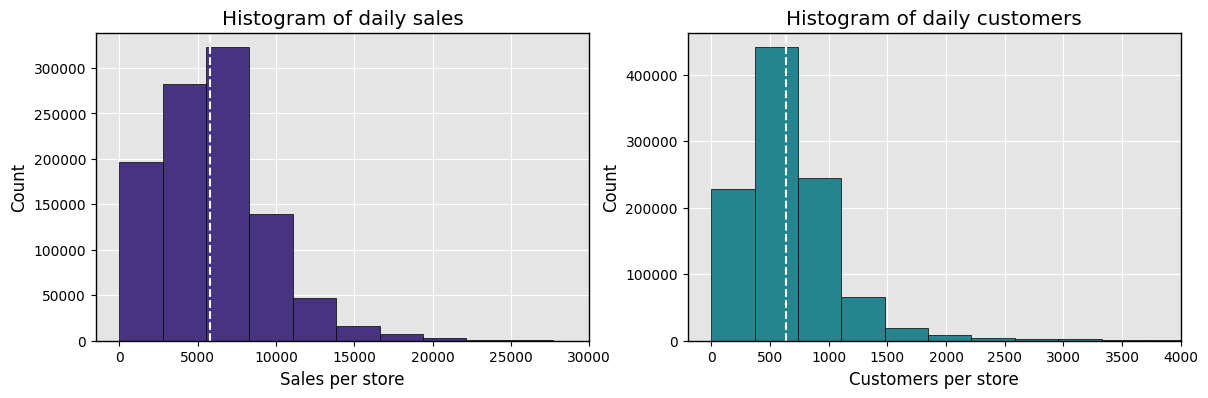

In [9]:
average_sales = dataset.Sales.mean()
average_customers = dataset.Customers.mean()

display(dataset.Sales.describe())
display(dataset.Customers.describe())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.hist(dataset.Sales, bins=15, color=vir_col(0.15), edgecolor="black")
ax1.set_xbound(-1500, 30000)
ax1.set_title("Histogram of daily sales")
ax1.set_xlabel("Sales per store")
ax1.set_ylabel("Count")
ax1.axvline(average_sales, c="white", linestyle="--")
ax2.hist(dataset.Customers, bins=20, color=vir_col(0.45), edgecolor="black")
ax2.set_xbound(-200, 4000)
ax2.set_title("Histogram of daily customers")
ax2.set_xlabel("Customers per store")
ax2.set_ylabel("Count")
ax2.axvline(average_customers, c="white", linestyle="--")

plt.show()

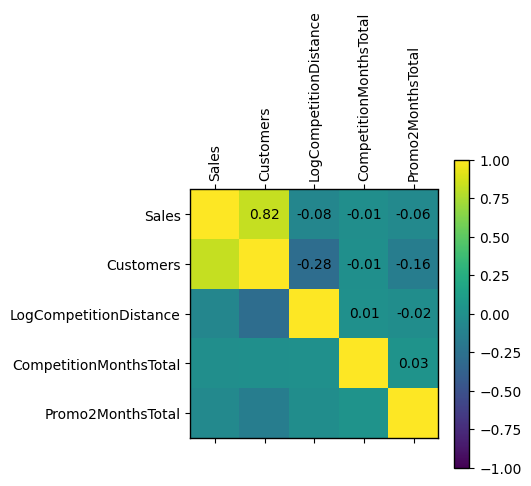

In [10]:
correlation_mat = dataset.loc[dataset.Open == 1, 
                                 ["Sales", 
                                  "Customers", 
                                  "LogCompetitionDistance", 
                                  "CompetitionMonthsTotal", 
                                  "Promo2MonthsTotal"]
                                 ].corr()

fig, ax = plt.subplots(figsize=(4,4))

cax = ax.matshow(correlation_mat, vmin=-1, vmax=1)
fig.colorbar(cax)

ax.set_xticks(range(len(correlation_mat.columns)))
ax.set_yticks(range(len(correlation_mat.columns)))
ax.set_xticklabels(correlation_mat.columns)
ax.set_yticklabels(correlation_mat.columns)

for i in range(len(correlation_mat.columns)-1):
    for j in range(i+1, len(correlation_mat.columns)):
        text = f"{correlation_mat.iloc[i, j]:.2f}"
        ax.text(j, i, text, ha="center", va="center", color="black")

ax.tick_params("x", rotation=90)
ax.grid(False)
plt.show()

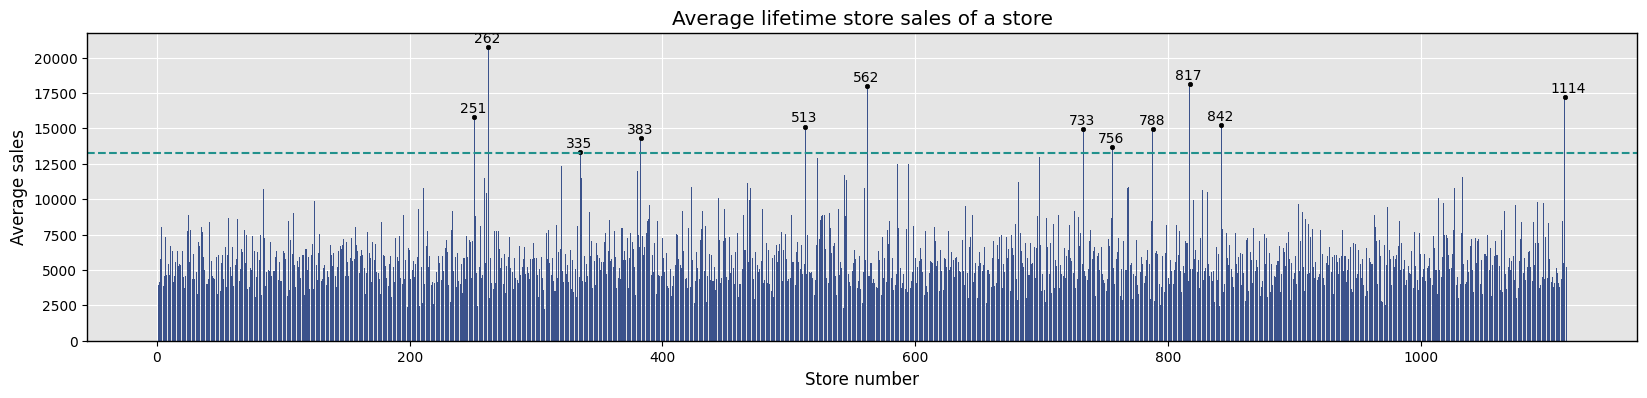

In [11]:
average_store_sales = dataset.groupby("Store").Sales.mean()
mean_quantile_99 = dataset.groupby("Store").Sales.mean().quantile(0.99)
better_than_q99 = average_store_sales[average_store_sales > mean_quantile_99]

fig, ax = plt.subplots(figsize=(20, 4))

ax.bar(average_store_sales.index, average_store_sales, color=vir_col(0.25))
ax.axhline(mean_quantile_99, linestyle="--", c=vir_col(0.5))
ax.scatter(better_than_q99.index, better_than_q99, c="black", s=10)
ax.set_title("Average lifetime store sales of a store")
ax.set_xlabel("Store number")
ax.set_ylabel("Average sales")

for store_id, value in better_than_q99.items():
    ax.annotate(str(store_id), (store_id - 0.01 * average_store_sales.shape[0], value + 0.025 * min(better_than_q99)))

plt.show()

In [12]:
dataset[dataset.Store.isin(better_than_q99.index)].groupby("Store").agg({
    "Promo": "first",
    "StoreType": "first",
    "Assortment": "first",
    "LogCompetitionDistance": "first",
    "Promo2": "first",
    "Customers": "mean"
})

,Promo,StoreType,Assortment,LogCompetitionDistance,Promo2,Customers
Store,,,,,,
251,1,a,c,5.83,0,2026.47
262,1,b,a,7.07,0,3402.01
335,1,b,a,4.50,1,2385.28
383,1,a,c,5.86,0,1826.17
513,1,a,a,5.99,0,1744.72
562,1,b,c,7.10,0,3105.05
733,1,b,b,6.76,0,3403.46
756,1,a,c,3.91,1,1940.53
788,1,a,c,7.33,0,1429.76


#### As we can see on the lower plots, these stores actually aren't the best performing, they're just the largest, thus totaling better sales than smaller stores

- that can be fixed by looking at the average sales by store per each individual person going into the store.

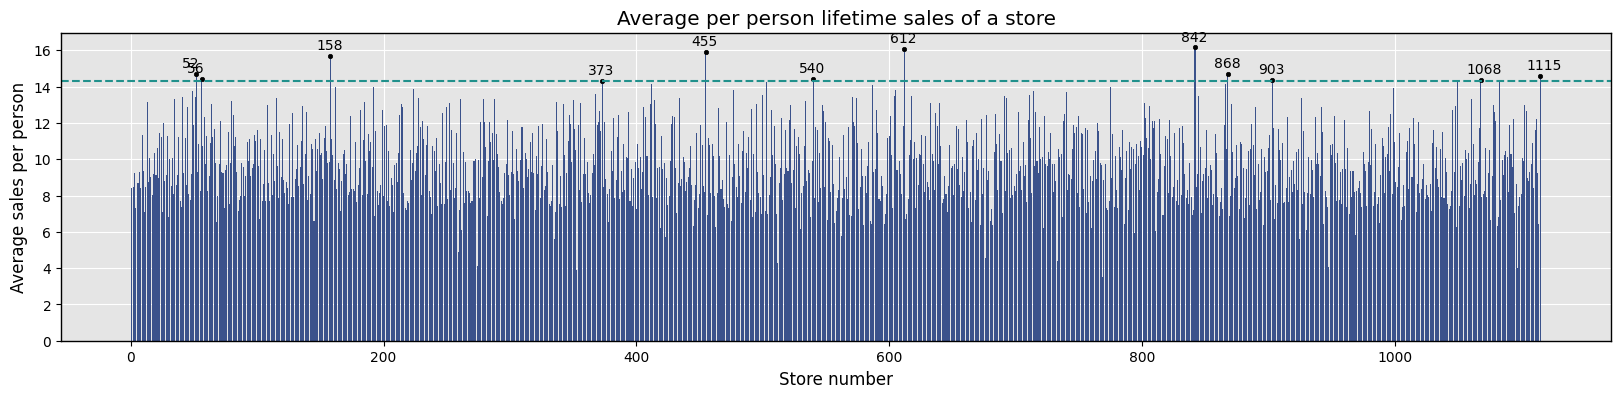

In [13]:
average_store_sales_per_person = dataset.groupby("Store").Sales.mean() / dataset.groupby("Store").Customers.mean()
mean_quantile_99_per_person = average_store_sales_per_person.quantile(0.99)
better_than_q99_per_person = average_store_sales_per_person[average_store_sales_per_person > mean_quantile_99_per_person]

fig, ax = plt.subplots(figsize=(20, 4))

ax.bar(average_store_sales_per_person.index, average_store_sales_per_person, color=vir_col(0.25))
ax.axhline(mean_quantile_99_per_person, linestyle="--", c=vir_col(0.5))
ax.scatter(better_than_q99_per_person.index, better_than_q99_per_person, c="black", s=10)
ax.set_title("Average per person lifetime sales of a store")
ax.set_xlabel("Store number")
ax.set_ylabel("Average sales per person")

for store_id, value in better_than_q99_per_person.items():
    ax.annotate(str(store_id), (store_id - 0.01 * average_store_sales_per_person.shape[0], value + 0.025 * min(better_than_q99_per_person)))

plt.show()

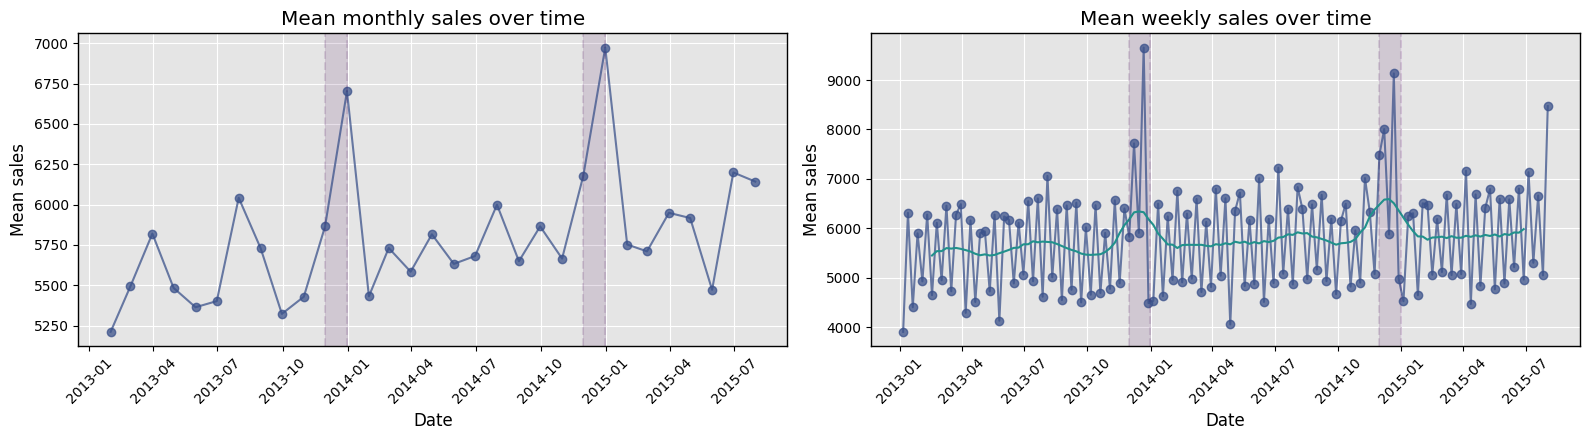

In [14]:
monthly_sales = dataset.groupby(pd.Grouper(key="Date", freq="ME")).Sales.mean()
weekly_sales = dataset.groupby(pd.Grouper(key="Date", freq="W")).Sales.mean()
fig, (ax1, ax2) = plt.subplots(1, 2, layout="tight", figsize=(16, 4.5))

ax1.plot(monthly_sales.index, monthly_sales.values, "o-", color=vir_col(0.25), alpha=0.75)
ax1.set_title("Mean monthly sales over time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Mean sales")
ax1.tick_params(axis="x", rotation=45)

ax2.plot(weekly_sales.index, weekly_sales.values, "o-", color=vir_col(0.25), alpha=0.75)
ax2.set_title("Mean weekly sales over time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Mean sales")
ax2.tick_params(axis="x", rotation=45)

weekly_sales_smooth = weekly_sales.rolling(window = 12, win_type="gaussian", center=True).mean(std=3)
ax2.plot(weekly_sales_smooth.index, weekly_sales_smooth, color=vir_col(0.5))

for axs in (ax1, ax2):
    for i in (10, 22):
        axs.axvline(monthly_sales.index[i], linestyle="--", c=vir_col(0), alpha=0.125) # December starting - shoping for holidays and Christmas
        axs.axvspan(monthly_sales.index[i], monthly_sales.index[i+1], color=vir_col(0), alpha=0.125)
        axs.axvline(monthly_sales.index[i+1], linestyle="--", c=vir_col(0), alpha=0.125)

plt.show()


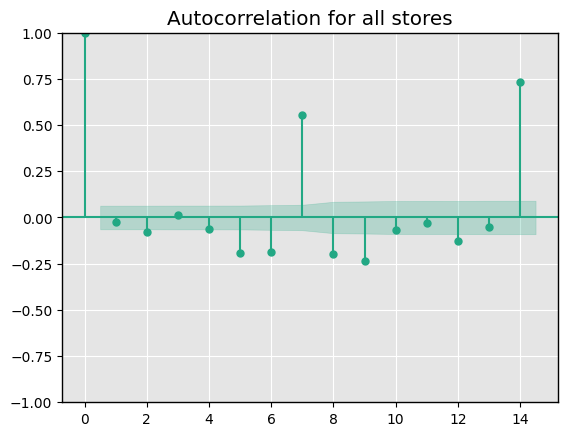

In [15]:
fig = plot_acf(dataset.groupby("Date").Sales.mean(), lags=14, color=vir_col(0.6))
ax = fig.axes[0]
for line in ax.collections:
    line.set_color(vir_col(0.6))
ax.set_title("Autocorrelation for all stores")
plt.show()

#### If we compare the plot under with the one before, we can see that the correlation shifts for the open shops
- this might be because most of the stores are closed during sundays, so the correlation gets artificially bumped by just one day of the week, thus reducing it's importance
- we will still add lag variables to the data (specifically 1, 2 and 7)

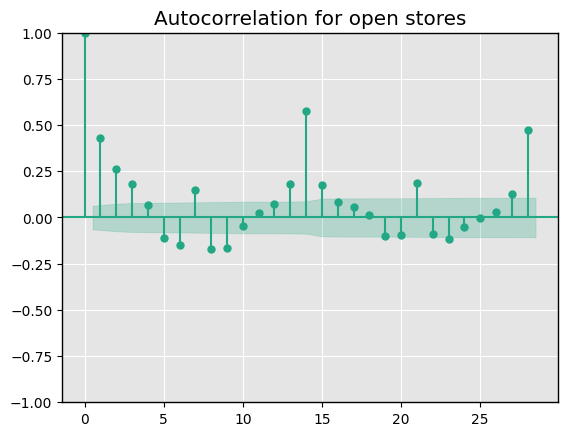

In [16]:
fig = plot_acf(dataset[dataset.Open == 1].groupby("Date").Sales.mean(), lags=28, color=vir_col(0.6))
ax = fig.axes[0]
for line in ax.collections:
    line.set_color(vir_col(0.6))
ax.set_title("Autocorrelation for open stores")
plt.show()

/tmp/ipykernel_5756/2627130345.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


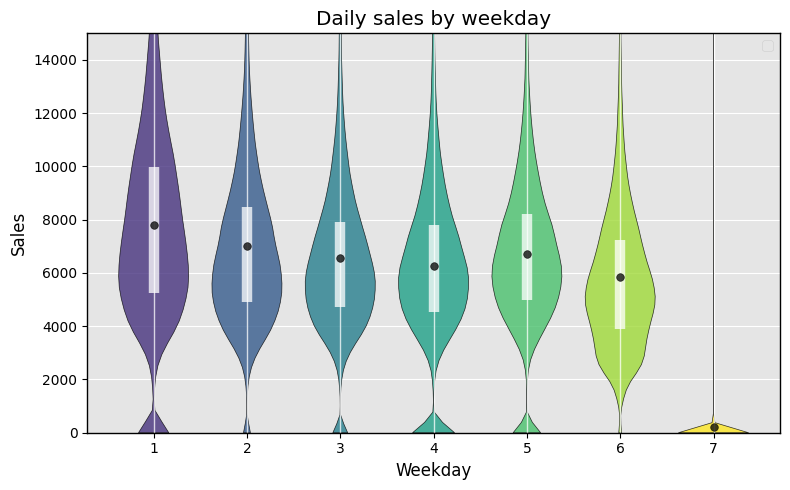

In [17]:
data_by_weekday = dataset.groupby("DayOfWeek")["Sales"].agg(list)

fig, ax = plt.subplots(layout="tight", figsize=(8, 5))

parts = ax.violinplot(data_by_weekday.tolist(), positions=range(1, len(data_by_weekday)+1), showextrema=False, widths=0.75)
for i, pc in enumerate(parts["bodies"]):
    pc.set_facecolor(vir_col((1 + i)* 1 / len(parts["bodies"])))
    pc.set_edgecolor("black")
    pc.set_alpha(0.8)

mean_values = dataset.groupby("DayOfWeek")["Sales"].mean()
quartile_1 = dataset.groupby("DayOfWeek")["Sales"].quantile(0.75)
quartile_3 = dataset.groupby("DayOfWeek")["Sales"].quantile(0.25)
ax.scatter(mean_values.index, mean_values, c="black", s=30, edgecolors="black", zorder=5, alpha=0.75)
ax.vlines(quartile_1.index, quartile_1, quartile_3, color="white", linewidth=7.5, alpha=0.75)
ax.vlines(quartile_1.index, 0, 15000, color="white", linewidth=1, alpha=0.75)

ax.set_title("Daily sales by weekday")
ax.set_xlabel("Weekday")
ax.set_ylabel("Sales")
ax.set_ylim(0, 15000)
ax.grid(True)
ax.legend()

plt.show()

/tmp/ipykernel_5756/1561372156.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  store_type_totals = dataset[["Store", "StoreType"]].drop_duplicates().groupby("StoreType").size().reset_index(name="Count")


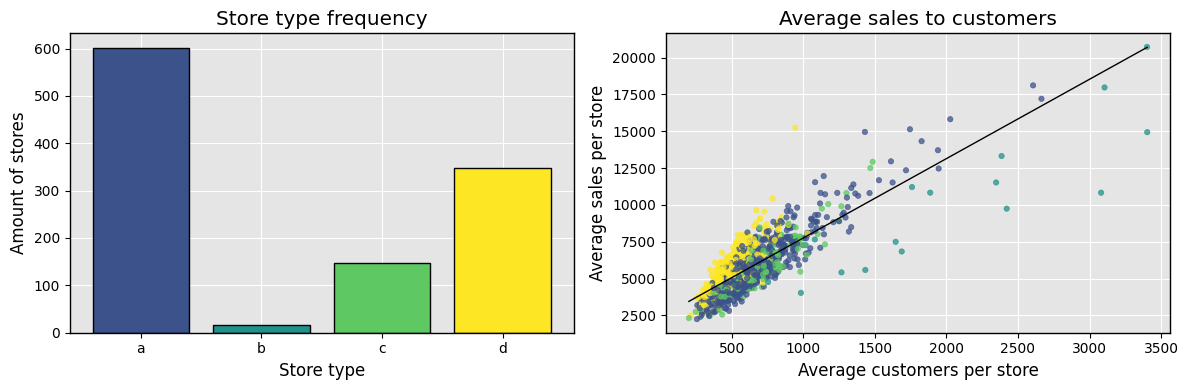

In [18]:
total_sales_to_customers = dataset.groupby("Store").agg({
    "Sales": "mean",
    "Customers": "mean",
    "StoreType": "first"
})

def get_color_list(col_param, variable):
    unique_values = dataset[variable].unique()
    color_list = {val: vir_col((i + col_param) * 1 / len(unique_values)) for i, val in enumerate(unique_values.sort_values())}
    return color_list

total_sales_to_customers["Colors"] = total_sales_to_customers.StoreType.astype(str).map(get_color_list(1, "StoreType"))
store_type_totals = dataset[["Store", "StoreType"]].drop_duplicates().groupby("StoreType").size().reset_index(name="Count")
store_type_totals["Colors"] = store_type_totals["StoreType"].astype(str).map(get_color_list(1, "StoreType"))

lin_mod = linregress(total_sales_to_customers["Customers"], total_sales_to_customers["Sales"])
x_for_model = np.linspace(min(total_sales_to_customers["Customers"]), max(total_sales_to_customers["Customers"]), num=1000)

fig, (ax1, ax2) = plt.subplots(1, 2, layout="tight", figsize=(12, 4))

ax1.bar(store_type_totals.StoreType, store_type_totals.Count, color=store_type_totals.Colors, edgecolor="black", linewidth=1)
ax1.set_title("Store type frequency")
ax1.set_xlabel("Store type")
ax1.set_ylabel("Amount of stores")
ax2.scatter(total_sales_to_customers.Customers, total_sales_to_customers.Sales, c=total_sales_to_customers.Colors, s=15, alpha=0.75)
ax2.plot(x_for_model, lin_mod.intercept + x_for_model * lin_mod.slope, c="black", linewidth=1)
ax2.set_title("Average sales to customers")
ax2.set_xlabel("Average customers per store")
ax2.set_ylabel("Average sales per store")

plt.show()

/tmp/ipykernel_5756/1246021346.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  store_type_totals = dataset[["Store", "Assortment"]].drop_duplicates().groupby("Assortment").size().reset_index(name="Count")
/tmp/ipykernel_5756/1246021346.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(["basic", "extra", "extended"])


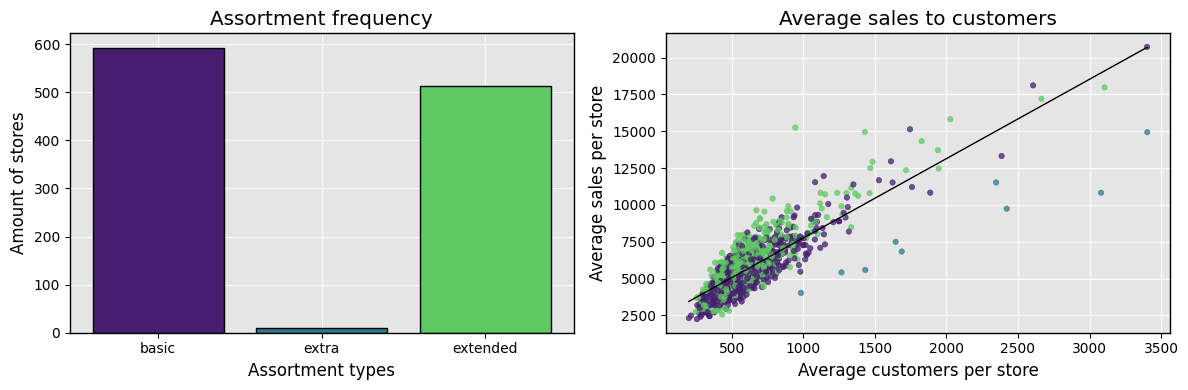

In [19]:
total_sales_to_customers = dataset.groupby("Store").agg({
    "Sales": "mean",
    "Customers": "mean",
    "Assortment": "first"
})

total_sales_to_customers["Colors"] = total_sales_to_customers.Assortment.astype(str).map(get_color_list(0.25, "Assortment"))
store_type_totals = dataset[["Store", "Assortment"]].drop_duplicates().groupby("Assortment").size().reset_index(name="Count")
store_type_totals["Colors"] = store_type_totals["Assortment"].astype(str).map(get_color_list(0.25, "Assortment"))

lin_mod = linregress(total_sales_to_customers["Customers"], total_sales_to_customers["Sales"])
x_for_model = np.linspace(min(total_sales_to_customers["Customers"]), max(total_sales_to_customers["Customers"]), num=1000)

fig, (ax1, ax2) = plt.subplots(1, 2, layout="tight", figsize=(12, 4))
ax1.bar(store_type_totals.Assortment, store_type_totals.Count, color=store_type_totals.Colors, edgecolor="black", linewidth=1)
ax1.set_title("Assortment frequency")
ax1.set_xlabel("Assortment types")
ax1.set_ylabel("Amount of stores")
ax1.set_xticklabels(["basic", "extra", "extended"])
ax2.scatter(total_sales_to_customers.Customers, total_sales_to_customers.Sales, c=total_sales_to_customers.Colors, s=15, alpha=0.75)
ax2.plot(x_for_model, lin_mod.intercept + x_for_model * lin_mod.slope, c="black", linewidth=1)
ax2.set_title("Average sales to customers")
ax2.set_xlabel("Average customers per store")
ax2.set_ylabel("Average sales per store")

plt.show()

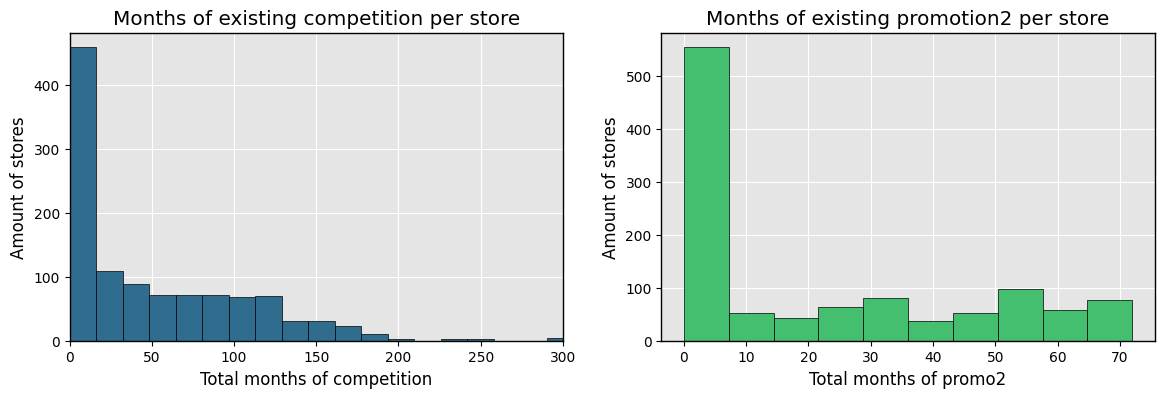

In [20]:
competition_months = dataset.groupby("Store").agg({
    "CompetitionMonthsTotal": "first"
})

promo2_months = dataset.groupby("Store").agg({
    "Promo2MonthsTotal": "first"
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.hist(competition_months, bins=40, color=vir_col(0.35), edgecolor="black")
ax1.set_title("Months of existing competition per store")
ax1.set_xlabel("Total months of competition")
ax1.set_ylabel("Amount of stores")
ax1.set_xbound(0, 300)
ax2.hist(promo2_months, color=vir_col(0.7), edgecolor="black")
ax2.set_title("Months of existing promotion2 per store")
ax2.set_xlabel("Total months of promo2")
ax2.set_ylabel("Amount of stores")

plt.show()

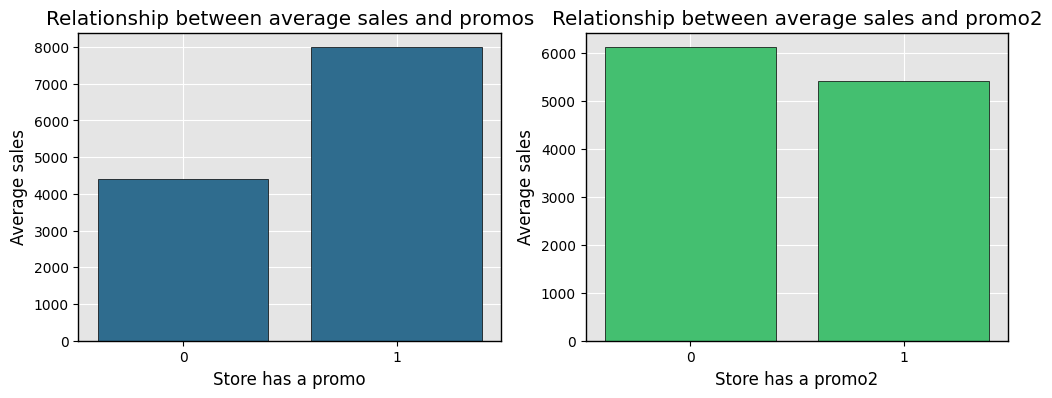

In [21]:
sales_by_promo = dataset.groupby("Promo").Sales.mean()
sales_by_promo2 = dataset.groupby("Promo2").Sales.mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(sales_by_promo.index.astype(str), sales_by_promo, color=vir_col(0.35), edgecolor="black")
ax1.set_title("Relationship between average sales and promos")
ax1.set_xlabel("Store has a promo")
ax1.set_ylabel("Average sales")

ax2.bar(sales_by_promo2.index.astype(str), sales_by_promo2, color=vir_col(0.70), edgecolor="black")
ax2.set_title("Relationship between average sales and promo2")
ax2.set_xlabel("Store has a promo2")
ax2.set_ylabel("Average sales")

plt.show()

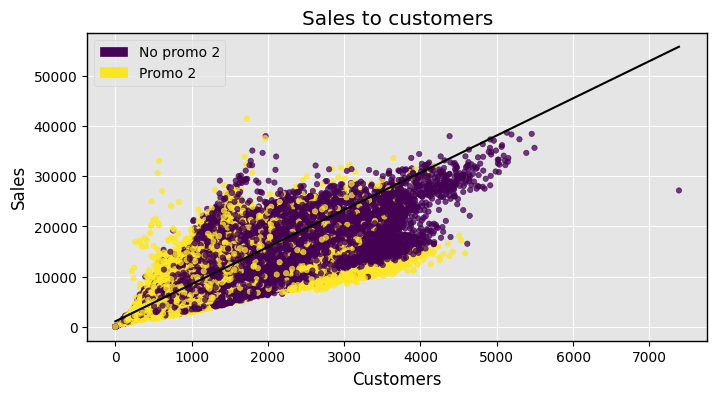

In [22]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.scatter(dataset.Customers, dataset.Sales, c=dataset.Promo2, alpha=0.75, s=15)
lin_mod = linregress(dataset.Customers, dataset.Sales)
x_for_model = np.linspace(min(dataset.Customers), max(dataset.Customers), num=1000)

ax.plot(x_for_model, lin_mod.intercept + lin_mod.slope * x_for_model, color="black")
ax.set_title("Sales to customers")
ax.set_xlabel("Customers")
ax.set_ylabel("Sales")

legend_handles = [
    mpatches.Patch(color=vir_col(0.01), label="No promo 2"),
    mpatches.Patch(color=vir_col(0.99), label='Promo 2')
]

plt.legend(handles=legend_handles)
plt.show()